In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
# text 데이터 컬럼에 true인 사전 생성
def make_choice_dic(data, columne_name):
    choice_list = [False for i in range(len(columne_name))]
    lenpriorlist = []
    for name in columne_name:
        lencolone = len(data[name][0])
        lenpriorlist.append(lencolone)
    true_index = lenpriorlist.index(max(lenpriorlist))
    choice_list[true_index] = True
    choice_dic = {name : value for name, value in zip(columne_name, choice_list)}
    return choice_dic

# 데이터 중복 제거 및 Null값 제거
def cut_dup_null(data, columne_name, choice_dic):
    print('전체 샘플수 :', len(data))
    for name in columne_name:
        if choice_dic[name]:
            data.drop_duplicates(subset = name, inplace=True)
        data.replace('', np.nan, inplace=True)
        data.dropna(axis=0, inplace=True)
    print('전처리 이후 샘플수 :', len(data))
    return data

# 불용어 삭제 및 텍스트 정규화
def cut_stopword(data, columne_name, choice_dic, contractions):
    def preprocess_sentence(sentence, remove_stopwords):
        sentence = sentence.lower()
        sentence = BeautifulSoup(sentence, "lxml").text
        sentence = re.sub(r'\([^)]*\)', '', sentence)
        sentence = re.sub('"','', sentence)
        sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
        sentence = re.sub(r"'s\b","", sentence)
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        sentence = re.sub('[m]{2,}', 'mm', sentence)
        
        if remove_stopwords:
            tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
            
        else:
            tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
            
        return tokens
    
    return_data = []
    for name in columne_name:
        return_col = []
        for seq in data[name]:
            tokens = preprocess_sentence(seq, choice_dic[name])
            return_col.append(tokens)
        return_data.append(return_col)
        
    for i, name in enumerate(columne_name):
        data[name] = return_data[i]
        
    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0, inplace=True)
        
    return data

# 샘플 길이 결정을 위한 시각화 함수
def visual_len(data, columne_name, choice_dic):
    for name in columne_name:
        if choice_dic[name]:
            text_len = [len(s.split()) for s in data[name]]
        else:
            summary_len = [len(s.split()) for s in data[name]]
        
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    print('텍스트의 길이 분산 : {}'.format(np.var(text_len)))
    print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
    print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
    print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))
    print('요약의 길이 분산 : {}'.format(np.var(summary_len)))
    
    plt.title('Text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    plt.title('Summary')
    plt.hist(summary_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

def per_len(data, choice_dic, max_len, wich_data=True):
    reverce_choice_dic = {v:k for k,v in choice_dic.items()}
    target_col = reverce_choice_dic[wich_data]
    
    cnt = 0
    
    for seq in data[target_col]:
        if (len(seq.split()) <= max_len):
            cnt = cnt + 1
    
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(data[target_col]))))
    
    return

def cut_long(data, columne_name, choice_dic, max_len, sub_max_len):
    return_list = []
    
    for name in columne_name:
        return_col = []
        cut_len = 0
        if choice_dic[name]:
            cut_len = max_len
        else:
            cut_len = sub_max_len
        for seq in data[name]:
            if len(seq.split()) > cut_len :
                return_seq = ''
            else :
                return_seq = seq
            return_col.append(return_seq)
        return_list.append(return_col)
        
    for i, name in enumerate(columne_name):
        data[name] = return_list[i]
        
    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0, inplace=True)
    
    print('길이 처리 이후 샘플 수 :', (len(data)))
    
    return data, max_len, sub_max_len


def add_token_split(data, columne_name, choice_dic, spilt_rate = 0.2, surffle = True):
    reverce_choice_dic = {v:k for k,v in choice_dic.items()}
    text_col = reverce_choice_dic[False]
    target_col = reverce_choice_dic[False]
    
    data['decoder_input'] = data[target_col].apply(lambda x : 'sostoken '+ x)
    data['decoder_target'] = data[target_col].apply(lambda x : x + ' eostoken')
    
    encoder_input = np.array(data[text_col])
    decoder_input = np.array(data['decoder_input'])
    decoder_target = np.array(data['decoder_target'])
    
    if surffle == True :
        indices = np.arange(encoder_input.shape[0])
        np.random.shuffle(indices)
        
        encoder_input = encoder_input[indices]
        decoder_input = decoder_input[indices]
        decoder_target = decoder_target[indices]
        
    n_of_val = int(len(encoder_input)*spilt_rate)
    
    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]
    
    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]
    
    return encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test

In [231]:
def check_voca_rate(encoder_input_train, decoder_input_train, e_word, d_word):
    src_tokenizer = Tokenizer()
    src_tokenizer.fit_on_texts(encoder_input_train)
    
    tar_tokenizer = Tokenizer()
    tar_tokenizer.fit_on_texts(decoder_input_train)
    
    name_list = ['텍스트', '요약']
    tokenizer_list = [src_tokenizer.word_index, tar_tokenizer.word_index]
    word_num_list = [e_word, d_word]
    tokenizer_word_list = [src_tokenizer.word_counts.items(), tar_tokenizer.word_counts.items()]
    
    for tok, num, name, toki in zip(tokenizer_list, word_num_list, name_list, tokenizer_word_list):
        threshold = num
        total_cnt = len(tok)
        rare_cnt = 0
        total_freq = 0
        rare_freq = 0
        
        for key, value in toki:
            total_freq = total_freq + value
            if(value < threshold):
                rare_cnt = rare_cnt + 1
                rare_freq = rare_freq + value
            
        print(name + ' 단어 집합(vocabulary)의 크기 :', total_cnt)
        print(name + ' 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
        print(name + ' 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
        print(name + " 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
        print(name + " 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

        
def encoding_voca(encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test, src_vocab, tar_vocab, max_len=max_len, sub_max_len=sub_max_len):
    src_tokenizer = Tokenizer(num_words=src_vocab)
    src_tokenizer.fit_on_texts(encoder_input_train)
    
    tar_tokenizer = Tokenizer(tar_vocab)
    tar_tokenizer.fit_on_texts(decoder_input_train)
    tar_tokenizer.fit_on_texts(decoder_target_train)
    
    encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
    encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
    decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
    decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
    decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
    decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
    
    drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
    drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
    
    encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
    decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
    decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]
    
    encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
    decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
    decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]
    
    print('훈련 데이터의 개수 :', len(encoder_input_train))
    print('훈련 레이블의 개수 :', len(decoder_input_train))
    print('테스트 데이터의 개수 :', len(encoder_input_test))
    print('테스트 레이블의 개수 :', len(decoder_input_test))
    
    encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_len, padding='pre')
    encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_len, padding='pre')
    decoder_input_train = pad_sequences(decoder_input_train, maxlen=sub_max_len, padding='pre')
    decoder_target_train = pad_sequences(decoder_target_train, maxlen=sub_max_len, padding='pre')
    decoder_input_test = pad_sequences(decoder_input_test, maxlen=sub_max_len, padding='pre')
    decoder_target_test = pad_sequences(decoder_target_test, maxlen=sub_max_len, padding='pre')
    
    return encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test, src_vocab, tar_vocab, src_tokenizer, tar_tokenizer


def decode_sequence(encoder_model, decoder_model, input_seq, tar_tokenizer=tar_tokenizer):
    tar_word_to_index = tar_tokenizer.word_index
    
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token
            
        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (sub_max_len-1)):
            stop_condition = True
            
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
        
    return decoded_sentence


def seq2text(input_seq, src_tokenizer=src_tokenizer):
    src_index_to_word = src_tokenizer.index_word
    
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
        return temp

def seq2summary(input_seq, tar_tokenizer=tar_tokenizer):
    tar_index_to_word = tar_tokenizer.index_word
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
        return temp

## 데이터 import 및 전처리

### 데이터 import

In [205]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data0 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 불용어 및 정규화 사전 생성

In [28]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))

정규화 사전의 수:  120
불용어 개수 : 179


### 데이터 전처리(불용어, 정규화, 중복값, 결측값)

In [51]:
columne_name = ['text', 'headlines']

choice_dic = make_choice_dic(data0, columne_name)

data1 = cut_dup_null(data0, columne_name, choice_dic)

data2, data3 = cut_stopword(data1, columne_name, choice_dic, contractions)

전체 샘플수 : 98360
전처리 이후 샘플수 : 98360


### 데이터 분할 및 텍스트 길이 설정

- 텍스트 길이를 설정하기 위해 분포 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 길이 분산 : 14.435335402905325
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534
요약의 길이 분산 : 1.932362530369967


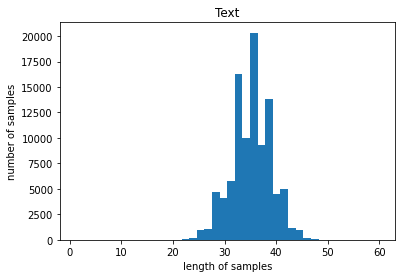

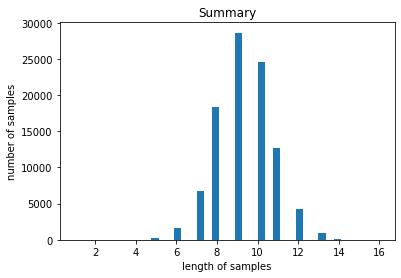

In [72]:
visual_len(data2, columne_name, choice_dic)

In [163]:
per_len(data2, choice_dic, 38, True)
per_len(data2, choice_dic, 10, False)

전체 샘플 중 길이가 38 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 1.0


- 위에서 확인한 분포 기반으로 길이 설정

In [206]:
data4, max_len, sub_max_len = cut_long(data2, columne_name, choice_dic, 38, 10)

길이 처리 이후 샘플 수 : 65295


- 데이터 분할 및 토큰화, 패딩

In [207]:
e_x_train, d_x_train, d_l_train, e_x_test, d_x_test, d_l_test = add_token_split(data4, columne_name, choice_dic, 0.2)

- 데이터 사전에 드문 데이터 제거

In [208]:
check_voca_rate(e_x_train, d_x_train, 7, 5)

텍스트 단어 집합(vocabulary)의 크기 : 25804
텍스트 등장 빈도가 6번 이하인 희귀 단어의 수: 18235
텍스트 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7569
텍스트 단어 집합에서 희귀 단어의 비율: 70.66733839714773
텍스트 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.295473520539716
요약 단어 집합(vocabulary)의 크기 : 25805
요약 등장 빈도가 4번 이하인 희귀 단어의 수: 16383
요약 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9422
요약 단어 집합에서 희귀 단어의 비율: 63.48769618291029
요약 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.488276418234908


In [209]:
e_x_train, d_x_train, d_l_train, e_x_test, d_x_test, d_l_test, src_vocab, tar_vocab, src_tokenizer, tar_tokenizer = encoding_voca(e_x_train, d_x_train, d_l_train, e_x_test, d_x_test, d_l_test, 8000, 4000)

훈련 데이터의 개수 : 52235
훈련 레이블의 개수 : 52235
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


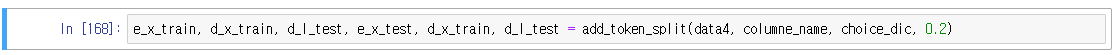
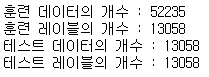
- 변수명으로 인하여 지속적으로 오류가 있었음

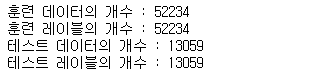
(정상 결과)


- 변수를 리스트로 함축하여 함수에 넣을 수 있다면 수정이 더 편이할 것

## 모델 구축 및 모델 학습

In [210]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

### 모델 구축

- 3층 구조 인코더 구조 구축
    - src_voca 및 max_len 값은 위에서 전처리 과정중 모두 저장해 둘 수 있게 해두었음
    
- 단일층 디코더 구조 구축
    - tar_vocab도 위 내용과 동일 준비하였음

- 어텐션 층 구축

In [211]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [212]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [213]:
# 어텐션 층
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [214]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 38, 128)      1024000     input_14[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 38, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 학습

In [215]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[e_x_train, d_x_train], y=d_l_train, \
          validation_data=([e_x_test, d_x_test], d_l_test), \
          batch_size=256, epochs=30)

Epoch 1/30
205/205 [==============================] - 16s 55ms/step - loss: 5.3770 - val_loss: 5.1203
Epoch 2/30
205/205 [==============================] - 10s 50ms/step - loss: 5.0336 - val_loss: 4.9224
Epoch 3/30
205/205 [==============================] - 10s 51ms/step - loss: 4.9474 - val_loss: 4.8555
Epoch 4/30
205/205 [==============================] - 11s 51ms/step - loss: 4.8723 - val_loss: 4.7896
Epoch 5/30
205/205 [==============================] - 10s 51ms/step - loss: 4.7871 - val_loss: 4.7125
Epoch 6/30
205/205 [==============================] - 10s 51ms/step - loss: 4.6974 - val_loss: 4.6403
Epoch 7/30
205/205 [==============================] - 10s 50ms/step - loss: 4.6119 - val_loss: 4.5775
Epoch 8/30
205/205 [==============================] - 10s 50ms/step - loss: 4.5316 - val_loss: 4.6021
Epoch 9/30
205/205 [==============================] - 10s 50ms/step - loss: 4.4630 - val_loss: 4.4667
Epoch 10/30
205/205 [==============================] - 10s 50ms/step - loss: 4.395

- 결과 확인

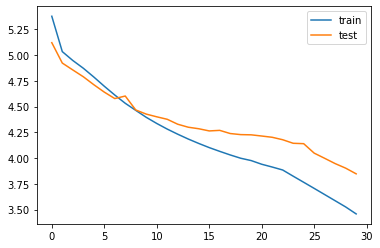

In [217]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 추론 모델 제작

### 모델 구축

In [218]:
# 인코더
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [219]:
# 디코더
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 층 (출력 문장에 길이에 따른 반복 구조를 위함)
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [220]:
# 어텐션 층
decoder_hidden_state_input = Input(shape=(max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [233]:
# 디코더 출력
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 모델 정의
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 추론 모델 구동

In [234]:
for i in range(50, 100):
    print("원문 :", seq2text(e_x_test[i]))
    print("실제 요약 :", seq2summary(d_x_test[i]))
    print("예측 요약 :", decode_sequence(encoder_model, decoder_model, e_x_test[i].reshape(1, max_len)))
    print("\n")

원문 : 
실제 요약 : 


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_2 is incompatible with the layer: expected axis -1 of input shape to have value 256 but received input with shape (None, 1, 512)


## summa 추출적 요약

In [216]:
from summa.summarizer import summarize

In [223]:
data_s = data0

In [224]:
summa_data = []

for seq in data_s['text']:
    sigle_summa_data = summarize(seq, words=50)
    summa_data.append(sigle_summa_data)

In [226]:
data_s['summa'] = summa_data

data_s.head()

,headlines,text,summa
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...","Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...
